# Data Integration & Preprocessing for Customer Satisfaction Analysis

This notebook is part of a larger project exploring customer satisfaction in Brazilian e-commerce using the [Olist dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).  
It builds on the cleaned datasets prepared in the previous notebook by joining them into a single analytical table, performing additional data cleaning, and engineering features to support the upcoming analysis.


**Goals of this notebook:**

- Join the cleaned tables into a consolidated dataset at the order level  
- Clean and standardize the merged dataset (e.g., data types, missing values)  
- Create new features to capture relevant aspects of orders, products, payments etc.
- Export the final dataset for analysis

**This notebook is preceded and followed by:**

- [Data Cleaning Notebook](./01_data_cleaning.ipynb): loads and prepares the individual raw datasets for integration  
- [Exploratory Analysis Notebook](./03_customer-satisfaction-analysis.ipynb): investigates customer satisfaction patterns and key influencing factors
---

## **Structure of the Notebook**

> _Note: Section links and “Back to top” links work best in Jupyter environments (e.g., Jupyter Lab or VS Code). They may not work as expected when clicked directly on GitHub._

- [Data Integration](#data-integration)
  - [Loading cleaned datasets](#loading-cleaned-csv-files-into-duckdb-tables)
  - [Joining tables into order-level dataset](#joining-tables-into-order-level-dataset)
- [Post-Merge Cleaning](#post-merge-cleaning)
  - [Initial inspection of joined dataset](#initial-inspection-of-joined-dataset)
  - [Handling missing values](#handling-missing-values)
  - [Handling implausible numeric values](#handling-implausible-numeric-values)
  - [Converting data types](#converting-data-types)
- Feature Engineering
  - Orders
    - Complexity
    - Price
    - Freight
    - Weight
  - Products
    - Product Categories
    - Product Presentation
    - Product Popularity
  - Shipping & Delivery
    - Delays
    - Delay Groups
  - Payments
  - Sellers
  - Geography
  - Review Scores
  - Convert data types for new feateres
- Export Final Dataset

In [83]:
import duckdb
import os
import sys
sys.path.append(os.path.abspath(".."))
import utils as u
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [84]:
# Set display options for better readability in output
pd.set_option("display.float_format", "{:,.2f}".format)

In [85]:
blue = "#0A2F4F"

## **Data Integration**

### **🔹Loading Cleaned CSV Files into DuckDB Tables**

In [86]:
# Path to the folder containing cleaned CSV files
data_path = "../data/cleaned"

# Connect to an in-memory DuckDB database
con = duckdb.connect(database=":memory:")

# List of table names to load
tables = [
    "customers",
    "orders",
    "items",
    "payments",
    "reviews",
    "products",
    "sellers",
]

# Create and load each table from CSV
for table in tables:
    con.execute(f"""
        CREATE TABLE {table} AS 
        SELECT * FROM read_csv_auto('{data_path}/{table}.csv');
    """)

[🠉 Back to top](#structure-of-the-notebook)

### **🔹Joining Tables into Order-Level Dataset**

To understand what drives **customer satisfaction**, we need a dataset that captures the entire customer experience — including products purchased, delivery timing, seller location, payment methods, and reviews.  
Since **reviews** are provided **for whole orders** rather than individual products, all features must be aggregated or merged to the **order level** to allow meaningful analysis.

To build this dataset, we:

- **Join** cleaned transactional tables — `items`, `products`, `sellers`, `orders`, `payments`, `reviews`, and `customers` — to gather all relevant data per order  
- **Aggregate** product-level data to the order level (e.g., summing prices, averaging product dimensions)
- **Capture variability** in product categories, sellers, and states:  
  - Orders with more than one product category are labeled `"multiple_categories"`  
  - Similarly, `"multiple_sellers"` and `"multiple_states"` indicate mixed-origin orders  
- **Summarize payment behavior** by counting payment records and installments per order  
- **Filter** the data to include only **delivered** orders with a **non-null review score**, ensuring we focus only on completed and rated transactions

This ensures that **each row corresponds to a unique order** and contains a rich set of features to analyze customer satisfaction drivers.

> _Note: Expandable sections (like "Click to expand") work best in interactive environments such as Jupyter Lab or VS Code. They may appear fully expanded on GitHub._

<details>
<summary><strong>How the Order-Level Dataset Was Built (Click to expand)</strong></summary>


**➤ `item_quantities` (Per-Product-Per-Order)**

- Combines `items`, `products`, and `sellers` to generate one row per product within each order.
- Handles nulls using `COALESCE` to label missing product categories or seller info as `'unknown'`.
- Aggregates:
  - `COUNT(*)` for number of times a product was purchased (product quantity)
  - `SUM(price)` and `SUM(freight_value)`
  - `MAX(product_weight_g)` and `MAX(shipping_limit_date)` for key logistics indicators
- Pulls product-level features using `AVG()` (later rounded) for:
  - `product_name_length`, `product_description_length`
  - `product_photos_qty`, `product_length_cm`, `product_height_cm`, `product_width_cm`

---

**➤ Product and Seller Categorization**

**`category_per_order`**
- If all items in an order share the same category → keep it.
- If there are multiple → label as `'multiple_categories'`.

**`seller_state_per_order` and `seller_id_per_order`**
- Same logic: return actual seller or state if unique, otherwise label as `'multiple_sellers'` or `'multiple_states'`.

**`product_features_per_order`**
- Averages and rounds product features at the order level to summarize size, content richness, and complexity of the products in the order.

---

**➤ `orders_items` (Aggregate Order Metrics)**

- Aggregates order content:
  - Number of **unique products** and **total quantity**
  - **Total price**, **freight**, and **total amount**
  - **Total order weight**

---

**➤ `payments_agg` (Payment Profile)**

- Aggregates payment behavior:
  - Max installments
  - Number of payment records
  - Aggregated distinct payment types (as a comma-separated string)

---

**➤ Final Output**

Combines all previous aggregations into a single **order-level** dataset and adds:

- Review score and timing info from `reviews`
- Actual vs. estimated delivery dates from `orders`
- Customer and seller metadata
- Product-level feature summaries

---

**➤ Final Filtering**

Only includes:
- Orders marked as **'delivered'**
- Orders that **have a review score**

</details>

In [87]:
# Build Query to Create Order-Level Dataset
q_orders = """
WITH item_quantities AS (
  -- Aggregate product and seller info per product in each order
  SELECT
    i.order_id,
    i.product_id,
    COALESCE(p.product_category_name_english, 'unknown') AS product_category_name,
    COALESCE(s.seller_state, 'unknown') AS seller_state,
    COALESCE(s.seller_id, 'unknown') AS seller_id,
    COUNT(*) AS product_quantity,
    SUM(i.price) AS product_price,
    SUM(i.freight_value) AS product_freight,
    MAX(p.product_weight_g) AS product_weight_g,
    MAX(i.shipping_limit_date) AS shipping_limit_date,
    AVG(p.product_name_lenght) AS product_name_length,
    AVG(p.product_description_lenght) AS product_description_length,
    AVG(p.product_photos_qty) AS product_photos_qty,
    AVG(p.product_length_cm) AS product_length_cm,
    AVG(p.product_height_cm) AS product_height_cm,
    AVG(p.product_width_cm) AS product_width_cm
  FROM items AS i
  LEFT JOIN products AS p ON i.product_id = p.product_id
  LEFT JOIN sellers AS s ON i.seller_id = s.seller_id
  GROUP BY i.order_id, i.product_id, s.seller_state, s.seller_id, p.product_category_name_english
),

-- Collapse product category into a single value per order
category_per_order AS (
  SELECT
    order_id,
    CASE 
      WHEN COUNT(DISTINCT product_category_name) = 1 
        THEN MAX(product_category_name)
      ELSE 'multiple_categories'
    END AS product_category_name
  FROM item_quantities
  GROUP BY order_id
),

-- Collapse seller state into a single value per order
seller_state_per_order AS (
  SELECT
    order_id,
    CASE 
      WHEN COUNT(DISTINCT seller_state) = 1 
        THEN MAX(seller_state)
      ELSE 'multiple_states'
    END AS seller_state
  FROM item_quantities
  GROUP BY order_id
),

-- Collapse seller ID into a single value per order
seller_id_per_order AS (
  SELECT
    order_id,
    CASE 
      WHEN COUNT(DISTINCT seller_id) = 1 
        THEN MAX(seller_id)
      ELSE 'multiple_sellers'
    END AS seller_id
  FROM item_quantities
  GROUP BY order_id
),

-- Collapse product ID into a single value per order
product_id_per_order AS (
  SELECT
    order_id,
    CASE 
      WHEN COUNT(DISTINCT product_id) = 1 
        THEN MAX(product_id)
      ELSE 'multiple_products'
    END AS product_id
  FROM item_quantities
  GROUP BY order_id
),

-- Average product-level features across items in the order
product_features_per_order AS (
  SELECT
    order_id,
    ROUND(AVG(product_name_length)) AS product_name_length,
    ROUND(AVG(product_description_length)) AS product_description_length,
    ROUND(AVG(product_photos_qty)) AS product_photos_qty,
    ROUND(AVG(product_length_cm)) AS product_length_cm,
    ROUND(AVG(product_height_cm)) AS product_height_cm,
    ROUND(AVG(product_width_cm)) AS product_width_cm
  FROM item_quantities
  GROUP BY order_id
),

-- Aggregate item-level purchase details per order
orders_items AS (
  SELECT
    order_id,
    COUNT(DISTINCT product_id) AS num_unique_products,
    ROUND(SUM(product_quantity)) AS num_items,
    SUM(product_price) AS total_price,
    SUM(product_freight) AS total_freight,
    SUM(product_price + product_freight) AS total_amount,
    SUM(product_quantity * product_weight_g) AS total_order_weight,
    MAX(shipping_limit_date) AS shipping_limit_date
  FROM item_quantities
  GROUP BY order_id
),

-- Aggregate payment details per order
payments_agg AS (
  SELECT
    order_id,
    MAX(payment_installments) AS max_payment_installments,
    COUNT(payment_sequential) AS n_payment_records, 
    STRING_AGG(DISTINCT payment_type, ', ' ORDER BY payment_type) AS payment_types,
    COUNT(DISTINCT payment_type) AS n_payment_types
  FROM payments
  GROUP BY order_id
)

------ Joined Order-Level Table ------
SELECT
  oi.order_id,
  r.review_score,
  pid.product_id,
  cat.product_category_name,
  oi.num_unique_products,
  oi.num_items,
  oi.total_price,
  oi.total_freight,
  oi.total_amount,
  oi.total_order_weight,
  pf.product_name_length,
  pf.product_description_length,
  pf.product_photos_qty,
  pf.product_length_cm,
  pf.product_height_cm,
  pf.product_width_cm,
  pa.payment_types,
  pa.n_payment_types,
  pa.max_payment_installments,
  pa.n_payment_records,
  oi.shipping_limit_date,
  o.order_delivered_carrier_date,
  o.order_delivered_customer_date,
  o.order_estimated_delivery_date,
  r.review_creation_date,
  r.review_answer_timestamp,
  c.customer_unique_id,
  c.customer_state,
  ssoid.seller_id,
  sso.seller_state

FROM orders_items AS oi
LEFT JOIN orders AS o USING(order_id)
LEFT JOIN customers AS c USING(customer_id)
LEFT JOIN payments_agg AS pa USING(order_id)
LEFT JOIN reviews AS r USING(order_id)
LEFT JOIN category_per_order AS cat USING(order_id)
LEFT JOIN seller_state_per_order AS sso USING(order_id)
LEFT JOIN seller_id_per_order AS ssoid USING(order_id)
LEFT JOIN product_features_per_order AS pf USING(order_id)
LEFT JOIN product_id_per_order AS pid USING(order_id)

-- Filter: only delivered orders with valid review scores
WHERE o.order_status = 'delivered' 
  AND r.review_score IS NOT NULL

ORDER BY oi.order_id;
"""

In [88]:
# Execute the final SQL query and convert the result to a pandas DataFrame
df_orders_raw = con.execute(q_orders).df()

# Show shape of the resulting dataset
print(
    f"Order-level joined table has {df_orders_raw.shape[0]} rows and {df_orders_raw.shape[1]} columns."
)

# Preview the first few rows
df_orders_raw.head()

Order-level joined table has 94782 rows and 30 columns.


,order_id,review_score,product_id,product_category_name,num_unique_products,num_items,total_price,total_freight,total_amount,total_order_weight,...,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_creation_date,review_answer_timestamp,customer_unique_id,customer_state,seller_id,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,5,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,1,1.00,58.90,13.29,72.19,650.00,...,2017-09-19 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09-21,2017-09-22 10:57:03,871766c5855e863f6eccc05f988b23cb,RJ,48436dade18ac8b2bce089ec2a041202,SP
1,00018f77f2f0320c557190d7a144bdd3,4,e5f2d52b802189ee658865ca93d83a8f,pet_shop,1,1.00,239.90,19.93,259.83,"30,000.00",...,2017-05-03 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-05-13,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,SP,dd7ddc04e1b6c2c614352b383efe2d36,SP
2,000229ec398224ef6ca0657da4fc703e,5,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,1,1.00,199.00,17.87,216.87,"3,050.00",...,2018-01-18 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01-23,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,MG,5b51032eddd242adc84c38acab88f23d,MG
3,00024acbcdf0a6daa1e931b038114c75,4,7634da152a4610f1595efa32f14722fc,perfumery,1,1.00,12.99,12.79,25.78,200.00,...,2018-08-15 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08-15,2018-08-15 16:39:01,af861d436cfc08b2c2ddefd0ba074622,SP,9d7a1d34a5052409006425275ba1c2b4,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,5,ac6c3623068f30de03045865e4e10089,garden_tools,1,1.00,199.90,18.14,218.04,"3,750.00",...,2017-02-13 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-03-02,2017-03-03 10:54:59,64b576fb70d441e8f1b2d7d446e483c5,SP,df560393f3a51e74553ab94004ba5c87,PR


In [89]:
# Close the DuckDB connection
con.close()

[🠉 Back to top](#structure-of-the-notebook)

## **Post-Merge Cleaning**

To ensure the original dataset remains unchanged, we create a copy before performing any cleaning operations.

In [90]:
# Create a copy of the raw joined DataFrame
df_orders = df_orders_raw.copy()

To keep the output readable and focused throughout the notebook, we define thematic column groups that are most relevant for analysis and anomaly detection. These groups make it easier to tailor displays depending on the context:

- `main_columns_basic`: essential identifiers and financial totals  
- `main_columns_product`: product-level attributes  
- `main_columns_payment`: payment-related columns  
- `main_columns_delivery`: delivery timing information  

These groups are then combined into a single `main_columns` list, which is used consistently when displaying samples of the dataset — for example, during missing value inspection or when exploring suspicious values.

In [91]:
# Display all column names for reference
df_orders.columns

Index(['order_id', 'review_score', 'product_id', 'product_category_name',
       'num_unique_products', 'num_items', 'total_price', 'total_freight',
       'total_amount', 'total_order_weight', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_types',
       'n_payment_types', 'max_payment_installments', 'n_payment_records',
       'shipping_limit_date', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_state', 'seller_id', 'seller_state'],
      dtype='object')

In [92]:
# Define key columns for display and inspection
main_columns_basic = [
    "order_id",
    "review_score",
    "product_id",
    "product_category_name",
    "num_items",
    "total_price",
    "total_freight",
    "total_amount",
]
main_columns_product = [
    "total_order_weight",
    "product_name_length",
    "product_description_length",
    "product_photos_qty",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
]
main_columns_payment = [
    "payment_types",
    "n_payment_types",
    "max_payment_installments",
    "n_payment_records",
]
main_columns_delivery = [
    "shipping_limit_date",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    'order_estimated_delivery_date',
]

# Combine columns groups into one list
main_columns = (main_columns_basic + main_columns_product + main_columns_payment + main_columns_delivery)

[🠉 Back to top](#structure-of-the-notebook)

### **🔹 Initial Inspection of Joined Dataset**

After joining the individual tables into an order-level dataset, we inspected  the structure and completeness of the resulting DataFrame.

#### ➤ Dataset Structure

In [93]:
# Display the summary of the DataFrame
u.summarize_table_shapes(df_orders)

,name,rows,columns,column_names,duplicates
0,df,94782,30,"[order_id, review_score, product_id, product_c...",0


The joined order-level dataset contains **94,782 rows** and **30 columns**.  
Importantly, there are **no duplicate rows**, ensuring the integrity of each order record in the final dataset.

#### ➤ Column-wise Overview

To better understand the dataset's composition, we now inspect the column-level properties such as data types, missing values, and number of unique entries

In [94]:
# Quick overview of column properties (dtypes, missing values, uniques)
u.column_overview(df_orders)

Df:


,dtype,non_null,missing_n,missing_%,uniques_n,uniques
order_id,object,94782,0,0.00,94782,"[00010242fe8c5a6d1ba2dd792cb16214, 00018f77f2f..."
review_score,int64,94782,0,0.00,5,"[5, 4, 1, 3, 2]"
product_id,object,94782,0,0.00,29848,"[4244733e06e7ecb4970a6e2683c13e61, e5f2d52b802..."
product_category_name,object,94782,0,0.00,75,"[cool_stuff, pet_shop, furniture_decor, perfum..."
num_unique_products,int64,94782,0,0.00,8,"[1, 2, 4, 3, 5, 6, 7, 8]"
num_items,float64,94782,0,0.00,17,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 7.0, 20.0,..."
total_price,float64,94782,0,0.00,7538,"[58.9, 239.9, 199.0, 12.99, 199.9, 21.9, 19.9,..."
total_freight,float64,94782,0,0.00,7831,"[13.29, 19.93, 17.87, 12.79, 18.14, 12.69, 11...."
total_amount,float64,94782,0,0.00,30320,"[72.19, 259.83, 216.87, 25.78, 218.04000000000..."
total_order_weight,float64,93471,1311,1.38,2827,"[650.0, 30000.0, 3050.0, 200.0, 3750.0, 450.0,..."


----------------------------------------------------------------------------------------------------------------------------------


> _Note: Expandable sections (like "Click to expand") work best in interactive environments such as Jupyter Lab or VS Code. They may appear fully expanded on GitHub._

<details>
<summary><strong>Key Insights — Missing Values & Data Types (Click to expand)</strong></summary>

**Missing Values**

The missing values fall into **three distinct groups**:
1. **Product-related attributes**  
   - `total_order_weight`, `product_name_length`, `product_description_length`, `product_photos_qty`, `product_length_cm`, `product_height_cm`, `product_width_cm`  
   → These values are missing for ~1,300 orders, likely due to unavailable product information or incomplete joins during merging.

2. **Payment-related attributes**  
   - `payment_types`, `n_payment_types`, `max_payment_installments`, `n_payment_records`  
   → A single row has missing values across these columns, possibly due to an unrecorded or failed transaction.

3. **Delivery date columns**  
   - `order_delivered_carrier_date`, `order_delivered_customer_date`  
   → Although the dataset was filtered to include only orders with `order_status = 'delivered'`, a small number of delivery dates are still missing. This could be due to inconsistencies or delays in data recording on the platform.

**Data Types**

Some columns with low cardinality and repeated string values (e.g. `product_category_name`, `payment_types`, `customer_state` or `seller_state`) are currently of `object` dtype.  
To improve memory efficiency and performance in grouping and aggregation tasks, we will convert them to the category dtype where applicable.

</details>

[🠉 Back to top](#structure-of-the-notebook)

#### ➤ Detecting Anomalies in Numeric Features

#### ⚠️ TODO: say that in this section we check for anomalies (really wrong values)

In [95]:
# Show descriptive statisticf for numeric columns
u.describe_numeric(df_orders)

Df:


,count,mean,std,min,25%,50%,75%,max
review_score,"94,782.00",4.16,1.28,1.00,4.00,5.00,5.00,5.00
num_unique_products,"94,782.00",1.04,0.23,1.00,1.00,1.00,1.00,8.00
num_items,"94,782.00",1.14,0.53,1.00,1.00,1.00,1.00,21.00
total_price,"94,782.00",137.08,208.31,0.85,45.90,86.90,149.90,"13,440.00"
total_freight,"94,782.00",22.76,21.51,0.00,13.84,17.17,24.00,"1,794.96"
total_amount,"94,782.00",159.84,218.01,9.59,61.84,105.28,176.36,"13,664.08"
total_order_weight,"93,471.00","2,390.26","4,774.41",0.00,300.00,750.00,"2,069.50","184,400.00"
product_name_length,"93,471.00",48.88,9.94,5.00,43.00,52.00,57.00,76.00
product_description_length,"93,471.00",795.02,652.60,4.00,352.00,609.00,998.00,"3,992.00"
product_photos_qty,"93,471.00",2.26,1.75,1.00,1.00,2.00,3.00,20.00


----------------------------------------------------------------------------------------------------------------------------------


#### ⚠️ TODO: write about anomalies found in .describe(): weight=0, max_payment_installments=0

[🠉 Back to top](#structure-of-the-notebook)

### **🔹Handling Missing Values**

#### ⚠️ TODO: say that in this section we will handle missing values identified in the previous section

#### ➤ Product-related attributes

#### ⚠️ TODO: explain what will be done in this section (identified more than 1300 missing values in each column)

#### ⚠️ TODO: explain why to create a flag for missing product attributes

In [96]:
# Create missing flag: 1 if any of the product-related fields is missing
df_orders["product_details_missing"] = (
    df_orders[main_columns_product].isna().any(axis=1).astype(int)
)

#### ⚠️ TODO: explain why to choose median for the missing values

In [97]:
# Median imputation
for col in main_columns_product:
    if df_orders[col].isna().any():
        median_value = df_orders[col].median()
        df_orders[col] = df_orders[col].fillna(median_value)

[🠉 Back to top](#structure-of-the-notebook)

#### ➤ Payment-related attributes

In [98]:
# Inspect rows with missing payment information
df_orders[df_orders[main_columns_payment].isna().any(axis=1)][main_columns_basic + main_columns_payment]


,order_id,review_score,product_id,product_category_name,num_items,total_price,total_freight,total_amount,payment_types,n_payment_types,max_payment_installments,n_payment_records
70948,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,3.00,134.97,8.49,143.46,None,<NA>,<NA>,<NA>


We found that only one order has missing values in **payment-related columns**. Since the number of affected rows is minimal and there’s no obvious outlier behavior, we impute these missing values using the **mode** of each column. This ensures consistency with the most common payment patterns observed in the dataset.

In [99]:
# Impute missing payment-related values using the mode of each column
for col in main_columns_payment:
    if df_orders[col].isna().any():
        mode_value = df_orders[col].mode(dropna=True)[0]
        df_orders[col] = df_orders[col].fillna(mode_value)

#### ➤ Delivery date columns

In [100]:
# Inspect rows with missing delivery dates
df_orders[df_orders[main_columns_delivery].isna().any(axis=1)][main_columns_basic+main_columns_delivery]

,order_id,review_score,product_id,product_category_name,num_items,total_price,total_freight,total_amount,shipping_limit_date,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
4937,0d3268bad9b086af767785e3f0fc0133,5,ec165cd31c50585786ffda6feff5d0a6,toys,1.00,188.99,15.63,204.62,2018-07-05 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
12179,20edc82cf5400ce95e1afacc25798b31,5,55bfa0307d7a46bed72c492259921231,books_general_interest,1.00,45.90,9.07,54.97,2018-07-03 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19
15655,2aa91108853cecb43c84a5dc5b277475,5,44c2baf621113fa7ac95fa06b4afbc68,furniture_decor,1.00,179.00,14.98,193.98,2017-10-18 10:07:16,NaT,2017-11-20 19:44:47,2017-11-14
16550,2d1e2d5bf4dc7227b3bfebb81328c15f,5,a50acd33ba7a8da8e9db65094fa990a4,auto,1.00,117.30,17.53,134.83,2017-12-04 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
16719,2d858f451373b04fb5c984a1cc2defaf,5,30b5b5635a79548a48d04162d971848f,sports_leisure,1.00,179.00,15.00,194.00,2017-06-04 23:30:16,NaT,NaT,2017-06-23
17173,2ebdfc4f15f23b91474edf87475f108e,5,e7d5464b94c9a5963f7c686fc80145ad,watches_gifts,1.00,139.00,19.07,158.07,2018-07-05 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
63260,ab7c89dc1bf4a1ead9d6ec1ec8968a84,1,a2a7efc985315e86d4f0f705701b342b,computers_accessories,1.00,110.99,9.13,120.12,2018-06-18 12:30:35,2018-06-12 14:10:00,NaT,2018-06-26
85498,e69f75a717d64fc5ecdfae42b2e8e086,5,e7d5464b94c9a5963f7c686fc80145ad,watches_gifts,1.00,139.00,19.07,158.07,2018-07-05 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
91015,f5dd62b788049ad9fc0526e3ad11a097,5,2167c8f6252667c0eb9edd51520706a1,industry_commerce_and_business,1.00,329.00,25.24,354.24,2018-06-26 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16


#### ⚠️ TODO: explain why to drop the rows with missing delivery dates

In [101]:
# Drop orders with missing delivery dates, as these likely correspond to undelivered or cancelled orders
df_orders = df_orders.dropna(subset=main_columns_delivery)

# Reset index after dropping rows to keep DataFrame tidy
df_orders.reset_index(drop=True, inplace=True)

[🠉 Back to top](#structure-of-the-notebook)

### **🔹Handling Implausible Numeric Values**

#### ⚠️ TODO: write that in inspection section we found weird values in weight and installment columns that need to be explored and fixed

#### ➤ Payment installments = 0

#### ⚠️ Markdown: first explore the cases with 0 installments

In [102]:
# Explore rows where max_payment_installments is 0

# Check how many rows have 0 installments
num_zero_installments = (df_orders["max_payment_installments"] == 0).sum()
print(f"Number of rows with max_payment_installments = 0: {num_zero_installments}")

# Display a few sample rows with this issue to inspect further
df_zero_installments = df_orders[df_orders["max_payment_installments"] == 0][main_columns_basic+main_columns_payment]
print("Sample rows with max_payment_installments = 0:")
display(df_zero_installments.head())

Number of rows with max_payment_installments = 0: 2
Sample rows with max_payment_installments = 0:


,order_id,review_score,product_id,product_category_name,num_items,total_price,total_freight,total_amount,payment_types,n_payment_types,max_payment_installments,n_payment_records
9765,1a57108394169c0b47d8f876acc9ba2d,5,db35a562fb6ba63e19fa42a15349dc04,housewares,2.00,83.38,46.56,129.94,credit_card,1,0,1
42987,744bade1fcf9ff3f31d860ace076d422,5,0cf573090c66bb30ac5e53c82bdb0403,telephony,1.00,45.90,12.79,58.69,credit_card,1,0,1


#### ⚠️ Markdown: only two rows, will impute with mode

In [103]:
# Get mode from valid (non-zero) values
mode_installments = df_orders[df_orders["max_payment_installments"] > 0][
    "max_payment_installments"
].mode()[0]

# Impute 0 values with mode
df_orders.loc[
    df_orders["max_payment_installments"] == 0, "max_payment_installments"
] = mode_installments

# Confirm the fix
assert (df_orders["max_payment_installments"] == 0).sum() == 0, (
    "There are still zero values left!"
)

[🠉 Back to top](#structure-of-the-notebook)

#### ➤ Total Order Weight = 0

In [104]:
# Investigating implausible values: total_order_weight = 0

# Count how many orders have zero total weight
n_zero_weight = (df_orders["total_order_weight"] == 0).sum()
print(f"Number of orders with total_order_weight = 0: {n_zero_weight}")

# Look at the cases with zero total weight
df_zero_weight = df_orders[df_orders["total_order_weight"] == 0][
    main_columns_basic + ["total_order_weight", "seller_id"]
]
display(df_zero_weight)

Number of orders with total_order_weight = 0: 6


,order_id,review_score,product_id,product_category_name,num_items,total_price,total_freight,total_amount,total_order_weight,seller_id
2500,06afc1144eb9f51ef2aa90ec9223c7f4,3,e673e90efa65a5409ff4196c038bb5af,bed_bath_table,2.00,259.80,47.42,307.22,0.00,b39d7fe263ef469605dbb32608aee0af
2568,06d9e69034388abf6da64378e10737b8,3,36ba42dd187055e1fbe943b2d11430ca,bed_bath_table,2.00,200.00,47.70,247.70,0.00,b39d7fe263ef469605dbb32608aee0af
11855,200b121c28e10ef638131a7c76753327,5,81781c0fed9fe1ad6e8c81fca1e1cb08,bed_bath_table,1.00,100.00,19.89,119.89,0.00,b39d7fe263ef469605dbb32608aee0af
26401,476b812a7e4fc972646eb390517bddcb,5,e673e90efa65a5409ff4196c038bb5af,bed_bath_table,1.00,129.90,23.71,153.61,0.00,b39d7fe263ef469605dbb32608aee0af
27679,4abc7b5330425bcf9c2f7f48151a88c0,5,8038040ee2a71048d4bdbbdc985b69ab,bed_bath_table,1.00,129.90,14.49,144.39,0.00,b39d7fe263ef469605dbb32608aee0af
66694,b489f7ae130ba3fd26b0a20f8cc81c61,5,e673e90efa65a5409ff4196c038bb5af,bed_bath_table,1.00,129.90,23.71,153.61,0.00,b39d7fe263ef469605dbb32608aee0af


We identified **6 orders** in the dataset where `total_order_weight` is equal to 0, which is not physically plausible. All of these orders belong to the `bed_bath_table` product category and were sold by the **same seller** (id `'b39d7fe263ef469605dbb32608aee0af'`)

Despite the weight being 0, the associated `total_price` and `total_freight` values appear reasonable, indicating that this is most likely a data entry error.

To impute implausible zero values in `total_order_weight`, we use a tailored approach:

- Filter orders from the same seller (`b39d...`) and same category (`bed_bath_table`)
- Calculate the **median weight per item** from valid rows
- Multiply this median by `num_items` for the 6 orders with `total_order_weight = 0`

This ensures consistency while respecting seller-specific product characteristics.

In [105]:
# Filter valid entries to calculate median weight per item for that seller + category
seller = "b39d7fe263ef469605dbb32608aee0af"
category = "bed_bath_table"

valid_rows = df_orders[
    (df_orders["seller_id"] == seller)
    & (df_orders["product_category_name"] == category)
    & (df_orders["total_order_weight"] > 0)
    & (df_orders["num_items"] > 0)
].copy()

# Calculate median weight per item
valid_rows["weight_per_item"] = (
    valid_rows["total_order_weight"] / valid_rows["num_items"]
)
median_weight_per_item = valid_rows["weight_per_item"].median()

print(
    f"Median weight per item for seller '{seller}' in category '{category}': {median_weight_per_item:.2f} g"
)

# Impute for rows where weight is 0 using num_items
mask_zero_weight = (
    (df_orders["total_order_weight"] == 0)
    & (df_orders["seller_id"] == seller)
    & (df_orders["product_category_name"] == category)
)

df_orders.loc[mask_zero_weight, "total_order_weight"] = (
    df_orders.loc[mask_zero_weight, "num_items"] * median_weight_per_item
)

Median weight per item for seller 'b39d7fe263ef469605dbb32608aee0af' in category 'bed_bath_table': 900.00 g


[🠉 Back to top](#structure-of-the-notebook)

### **🔹Converting Data Types**

To improve memory efficiency and ensure correct data representation, we inspect the current data types of all columns. Based on this, we identify opportunities to convert certain columns (particularly those with unnecessary float or object types) into more efficient dtypes.

In [106]:
u.column_overview(df_orders)

Df:


,dtype,non_null,missing_n,missing_%,uniques_n,uniques
order_id,object,94773,0,0.00,94773,"[00010242fe8c5a6d1ba2dd792cb16214, 00018f77f2f..."
review_score,int64,94773,0,0.00,5,"[5, 4, 1, 3, 2]"
product_id,object,94773,0,0.00,29845,"[4244733e06e7ecb4970a6e2683c13e61, e5f2d52b802..."
product_category_name,object,94773,0,0.00,75,"[cool_stuff, pet_shop, furniture_decor, perfum..."
num_unique_products,int64,94773,0,0.00,8,"[1, 2, 4, 3, 5, 6, 7, 8]"
num_items,float64,94773,0,0.00,17,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 7.0, 20.0,..."
total_price,float64,94773,0,0.00,7538,"[58.9, 239.9, 199.0, 12.99, 199.9, 21.9, 19.9,..."
total_freight,float64,94773,0,0.00,7831,"[13.29, 19.93, 17.87, 12.79, 18.14, 12.69, 11...."
total_amount,float64,94773,0,0.00,30319,"[72.19, 259.83, 216.87, 25.78, 218.04000000000..."
total_order_weight,float64,94773,0,0.00,2826,"[650.0, 30000.0, 3050.0, 200.0, 3750.0, 450.0,..."


----------------------------------------------------------------------------------------------------------------------------------


Since there are no missing values in the relevant columns, we can safely proceed with dtype conversions for optimization. These conversions will help reduce memory usage and improve performance in downstream operations.

We start by measuring the initial memory usage of the dataset before any optimizations. This will help us quantify the impact of each transformation.

In [107]:
# Define a function to measure memory usage
def report_memory(label):
    mem = df_orders.memory_usage(deep=True).sum() / 1024**2
    print(f"{label}: {mem:.2f} MB")
    return mem

# Measuring Initial Memory Usage
mem_initial = report_memory("Initial memory")

Initial memory: 66.28 MB


#### ➤ Converting Float Columns with Integer Values to Integer Types

Some `float` columns actually contain only whole numbers and can be safely downcasted to smaller integer types (e.g., `int8`, `int16`, `int32`). This reduces memory without changing the data.

In [108]:
# Get a list of all columns with float dtype
float_cols = df_orders.select_dtypes(include="float").columns.tolist()

# Initialize a list to store float columns that only contain integer values
convert_to_int_cols = []

# Loop through each float column and check if all values are whole numbers
for col in float_cols:
    if (df_orders[col] % 1 == 0).all():  # True if no decimal part
        convert_to_int_cols.append(col)

# Convert eligible columns to int if they have no missing values
for col in convert_to_int_cols:
    if df_orders[col].isna().sum() == 0:  # Only convert if there are no NaNs
        df_orders[col] = pd.to_numeric(df_orders[col], downcast="integer")
        print(f"{col} converted to {df_orders[col].dtype}")

# Measure memory usage after converting float columns to int
mem_after_int = report_memory("After float → int conversion")

num_items converted to int8
total_order_weight converted to int32
product_name_length converted to int8
product_description_length converted to int16
product_photos_qty converted to int8
product_length_cm converted to int8
product_height_cm converted to int8
product_width_cm converted to int8
After float → int conversion: 61.58 MB


#### ➤ Converting Low-Cardinality Object Columns to Category

Object columns with relatively few unique values (e.g. product categories, payment types) are great candidates for the `category` type. This conversion is highly memory-efficient and improves performance in filtering and grouping.

In [109]:
# Identify all columns with object dtype
object_cols = df_orders.select_dtypes(include="object").columns.tolist()

# Select object columns with low cardinality (less than 20% unique values)
# These are good candidates for conversion to 'category' type
category_candidates = [
    col for col in object_cols if df_orders[col].nunique() / len(df_orders[col]) < 0.2
]

# Convert selected columns to 'category' dtype to reduce memory usage
for col in category_candidates:
    df_orders[col] = df_orders[col].astype("category")

# Measure memory usage after converting object columns to category
mem_after_cat = report_memory("After object → category conversion")

After object → category conversion: 34.96 MB


In [110]:
# Summary
print(f"Total memory saved: {mem_initial - mem_after_cat:.2f} MB ({(mem_initial - mem_after_cat) / mem_initial:.0%} reduction)")

Total memory saved: 31.31 MB (47% reduction)


#### ➤ Final Result: Memory Optimization Summary

After both transformations, we significantly reduced the dataset size. Here's the breakdown:

| Step                          | Memory Usage |
|-------------------------------|--------------|
| Initial                       | 66.28 MB     |
| After float → int             | 61.58 MB     |
| After object → category       | 34.96 MB     |
| **Total saved**               | **31.31 MB**     |

These changes significantly reduce memory consumption (–47%) and make the dataset more efficient for downstream analysis and modeling.

[🠉 Back to top](#structure-of-the-notebook)

## **Feature Engineering**

### **🔹 Orders**

#### ⚠️ Add Markdown

#### ➤ Order Composition

#### ⚠️ Add Markdown

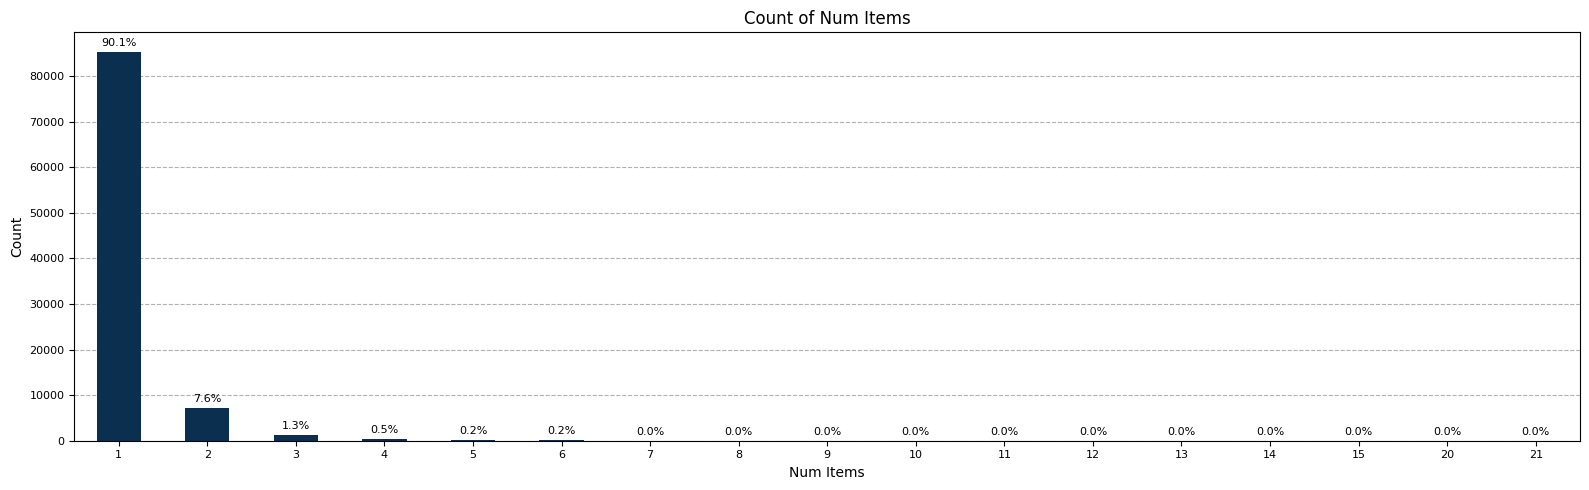

In [111]:
u.plot_value_counts(df_orders, "num_items", figsize=(16,5), sort='index')

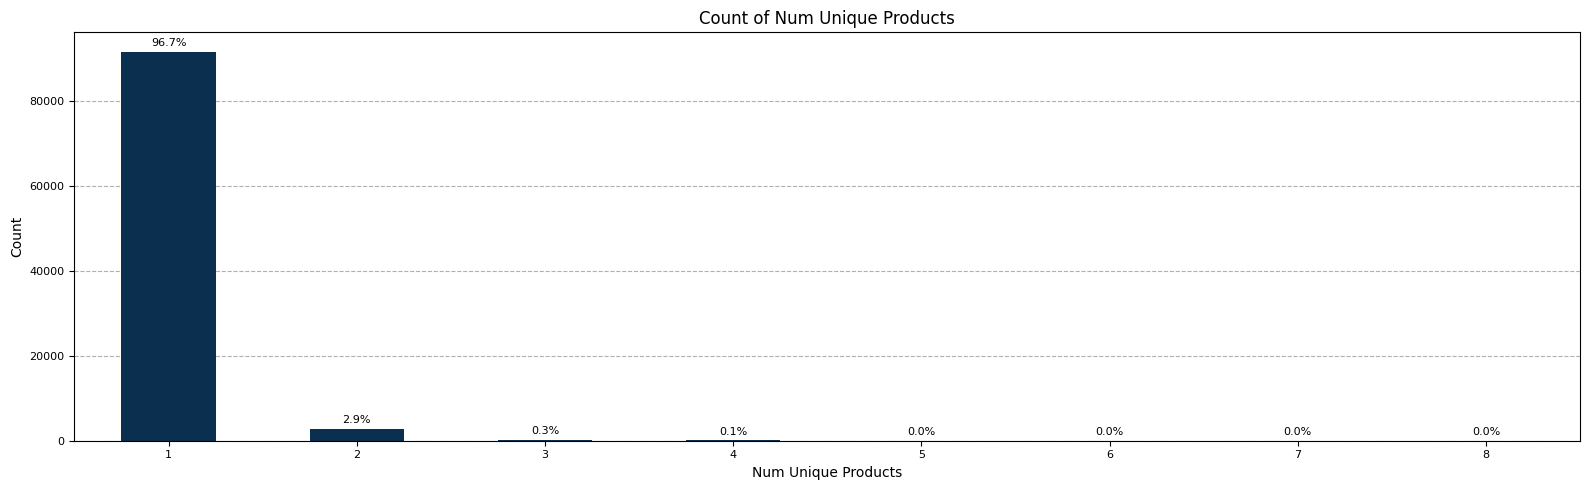

In [112]:
u.plot_value_counts(df_orders, "num_unique_products", figsize=(16, 5), sort="index")


In [113]:
# Binary flag: more than one item in the order
df_orders["has_multiple_items"] = (df_orders["num_items"] > 1).astype(int)

# Binary flag: more than one unique product in the order
df_orders["has_multiple_products"] = (df_orders["num_unique_products"] > 1).astype(int)

# Binary flag: more than one unique product in the order
df_orders["has_multiple_sellers"] = (df_orders["seller_id"] == "multiple_sellers").astype(int)

order_composition_cols = ["has_multiple_items", "has_multiple_products", "has_multiple_sellers"]

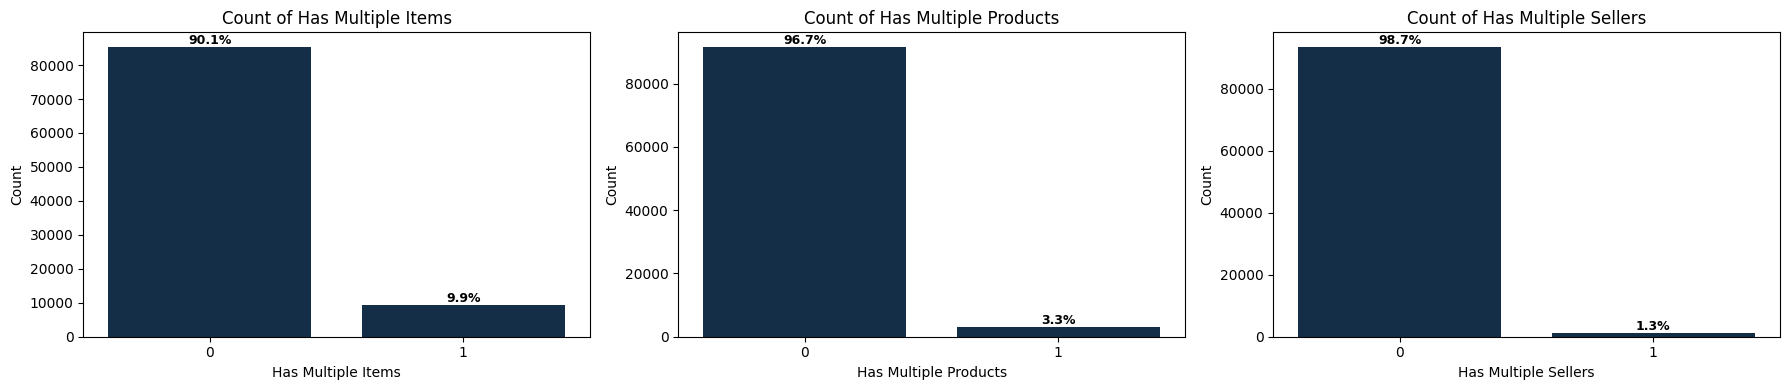

In [114]:
u.plot_countplots_grid(df_orders, order_composition_cols)

#### ➤ Price

Understanding the distribution of order prices can reveal important patterns about customer behavior and product value. Below we explore the distribution of the `total_price` variable, create custom price groups, and generate interpretable features for analysis.

We begin by inspecting the distribution of the total_price column using multiple visualizations.

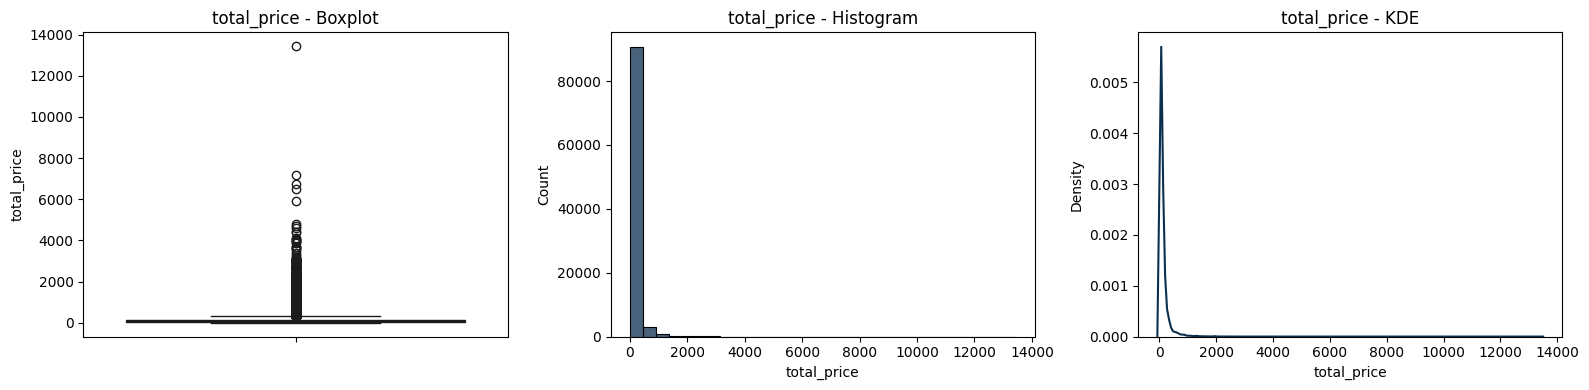

In [115]:
# Generate boxplot, histogram, and KDE plot for 'total_price'
u.numplots_univariate('total_price', df_orders)

The plots show a heavy right-skew in price values, with a long tail of outliers.

To better understand the main part of the distribution, we zoom in on the lower end:

In [116]:
# Display extended percentiles to understand the price spread
df_orders["total_price"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

count    94,773.00
mean        137.08
std         208.32
min           0.85
25%          45.90
50%          86.90
75%         149.90
90%         269.00
95%         399.00
99%         990.53
99.9%     2,251.05
99.99%    4,256.77
max      13,440.00
Name: total_price, dtype: float64

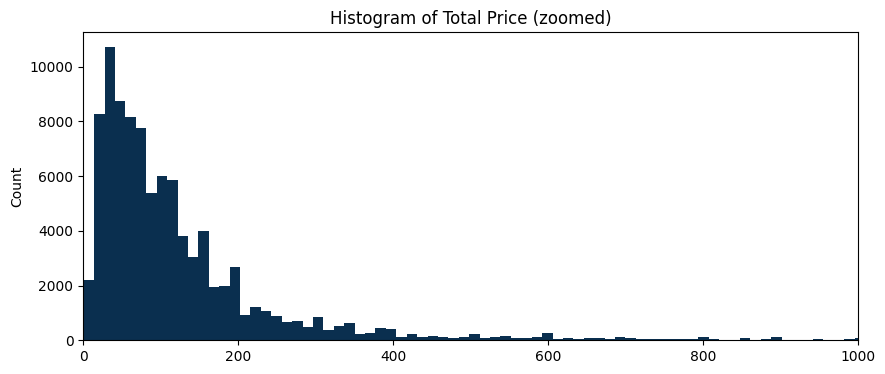

In [117]:
# Zoomed histogram of total_price up to 1000 BRL
plt.figure(figsize=(10, 4))
df_orders["total_price"].plot(kind="hist", bins=1000, color=blue)
plt.xlim(0, 1000)
plt.title("Histogram of Total Price (zoomed)")
plt.ylabel('Count')
plt.show()

**Creating Price Grouping Feature (`price_group`)**

While the 95th percentile of `total_price` is around **399 BRL**, we chose to define the highest price group as **500+ BRL** for the following reasons:

- **Clarity and interpretability**: 500 BRL is a clean, round threshold that is easier to interpret and communicate.
- **Outlier separation**: Orders above 500 BRL represent the top ~3–4% of all orders, which still captures the high-value outliers of the distribution.
- **Practical binning**: Using 500 as a cutoff avoids overly narrow bins at the top of the distribution and ensures a balance between statistical accuracy and usability.

The resulting bins are:
- `<50 BRL`
- `50–99 BRL`
- `100–199 BRL`
- `200–499 BRL`
- `500+ BRL`

This approach provides both data-driven and user-friendly segmentation.

In [118]:
# Define custom price bin edges and corresponding labels
price_bins = [0, 50, 100, 200, 500, np.inf]
price_labels = ["<50 BRL", "50–99 BRL", "100–199 BRL", "200–499 BRL", "500+ BRL"]

# Create a new column by grouping total_price into defined price ranges
df_orders["price_group"] = pd.cut(df_orders["total_price"], bins=price_bins, labels=price_labels, include_lowest=True)

# Convert the new price_group column to an ordered categorical type
# This ensures the bins have a defined logical order for sorting or plotting
df_orders["price_group"] = pd.Categorical(df_orders["price_group"], categories=price_labels, ordered=True)

We now visualize how orders are distributed across the defined price groups.

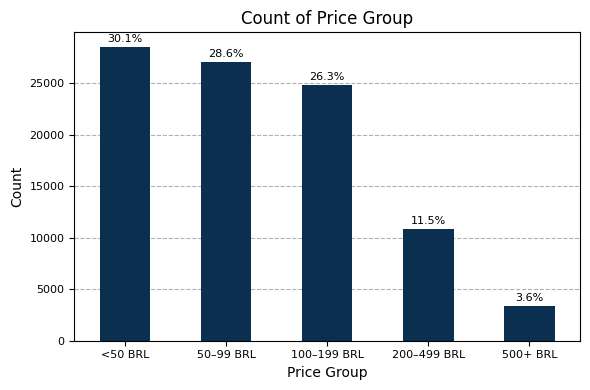

In [119]:
# Plot value counts of each price group
u.plot_value_counts(df_orders, "price_group")

The distribution confirms that most orders are priced under 200 BRL, with only ~3.6% falling into the 500+ BRL group.

**Creating a High-Price Flag Feature (`price_over_500`)**

To complement the price group segmentation, we introduce a binary feature that flags high-value orders with a **total price of 500 BRL or more**. 

High-price orders may be associated with different customer behavior or satisfaction patterns (e.g., higher expectations, increased return rates).

In [120]:
# Binary flag: 1 if the total price of the order is 500 BRL or more
df_orders["price_over_500"] = (df_orders["total_price"] >= 500).astype(int)